# Steganography prep

## Challenge 1: paint by numbers

In this challenge, the payload is an image made up of a small, arbitrary colour palette -- I've chosen the New Brunswick flag, which has only 5 colours in it. The id, $i$, for our payload colour is given by
$$ i = (r + g + b) \bmod N $$
where $r$, $g$, $b$ are the colour channels of the carrier, and $N$ is the number of colours in the payload (in this case, 5).

### Colour palette

I created the following mapping to and from the colour palette:

In [1]:
BLACK = (0, 0, 0)
BLUE = (26, 60, 134)
RED = (211, 41, 39)
GOLD = (244, 198, 0)
WHITE = (255, 255, 255)

# map integer id to RGB values
id_to_rgb = [BLACK, BLUE, RED, GOLD, WHITE]

# map '(r, g, b)' to integer id 
rgb_to_id = dict()
for v, k in enumerate(id_to_rgb):
    rgb_to_id[k] = v

### Image prep

It was a lot of work to force the flag picture to only 5 colours. PIL's `Image.quantize()` didn't pick the colours I wanted to keep. In the end, I hard-coded the decision process.

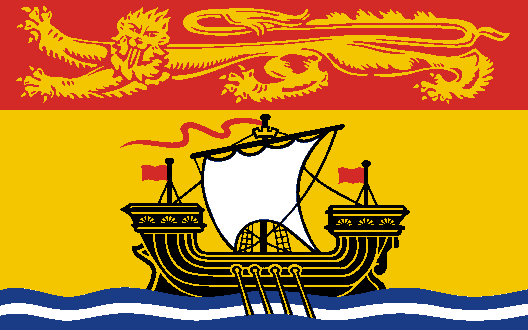

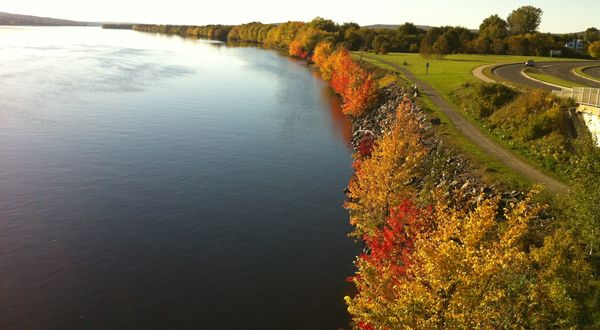

In [2]:
from PIL import Image
from IPython.display import display

payload = Image.open('nb_flag_sm.bmp')
for x in range(payload.width):
    for y in range(payload.height):
        
        r, g, b = payload.getpixel((x, y))
        
        if b > 50:
            if r < 150:
                r, g, b = BLUE
            else:
                r, g, b = WHITE
        elif r > 160:
            if g > 100:
                r, g, b = GOLD
            else:
                r, g, b = RED
        else:
            r, g, b = BLACK
        
        payload.putpixel((x,y), (r, g, b))
display(payload)

carrier = Image.open('westmoreland.png')
display(carrier)

### RGB adjustments

I need to be able to adjust arbitrary (r, g, b) tuples in order to produce a given "checksum", i.e. (r + g + b) % 5.  I decided to use all combinations of -1, 0, +1 for each channel; these are organized according to the change they make in checksum, then selected at random.

In [3]:
# possible adjustments for a given pixel, arranged by the net change to checksum

adj = [[], [], [], [], []]
for r in [-1, 0, 1]:
    for g in [-1, 0, 1]:
        for b in [-1, 0, 1]:
                adj[(r + g + b) % 5].append((r, g, b))

# hard-code adj[0] to no change
adj[0] = [(0, 0, 0)]

### Create the stego image

Start with the payload dimensions (we end up clipping the right side of the carrier a bit). Traverse the carrier pixel by pixel, nudging each (r, g, b) tuple as necessary.

The nudging process consists of the following steps:
  - check the unaltered checksum against the payload
  - randomly select an adjustment that produces the desired output
  - if any of the values are out of range, try again.

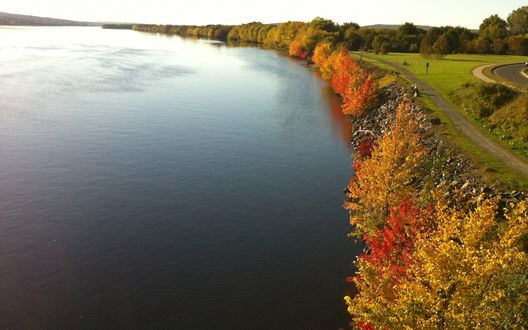

In [8]:
# necessary for randomized choice of adjustment
import random

# create the new image
stego = Image.new('RGB', payload.size)

# traverse the image
for x in range(stego.width):
    for y in range(stego.height):

        # get the colour id for this pixel in the payload
        payl_px = payload.getpixel((x, y))
        payl_id = rgb_to_id[payl_px]
        
        # get the checksum for this pixel in the carrier
        r, g, b = carrier.getpixel((x, y))
        checksum = (r + g + b) % 5
        
        # nudge as necessary
        while checksum != payl_id:
            
            # difference between desired, actual checksum used to select adjustment 
            diff = (payl_id - checksum + 5) % 5
            add_r, add_g, add_b = random.choice(adj[diff])
 
            # apply adjustment
            r += add_r
            g += add_g
            b += add_b

            # force to range 0-255
            r = min(max(r, 0), 255)
            g = min(max(g, 0), 255)
            b = min(max(b, 0), 255)

            # recalculate checksum
            checksum = (r + g + b) % 5
        
        # draw the adjusted pixel
        stego.putpixel((x, y), (r, g, b))

# check that the result looks convincing
display(stego)

### Reverse the process and generate the payload from the stego image

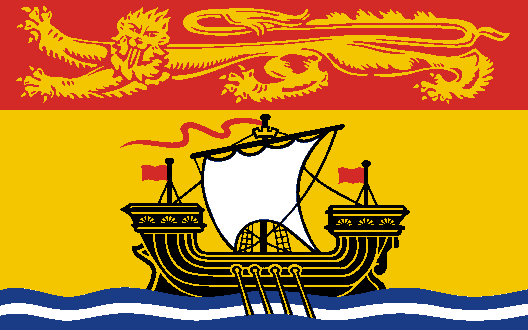

In [12]:
def unStego(img):
    '''Reverse the steganographic process and reveal the payload'''

    # create a new image, same size as stego
    payl = Image.new('RGB', img.size)

    # traverse the image
    for x in range(img.width):
        for y in range(img.height):

            # get the colour values for this pixel
            r, g, b = img.getpixel((x, y))

            # calculate the checksum
            checksum = (r + g + b) % 5

            # translate to corresponding colour
            payl.putpixel((x, y), id_to_rgb[checksum])

    return payl

# check the result
display(unStego(stego))

### Write the finished stego image

This will be the input for the students' challenge in lab.

In [11]:
stego.save('stego_1.png')

### Double-check that the process works on the saved file

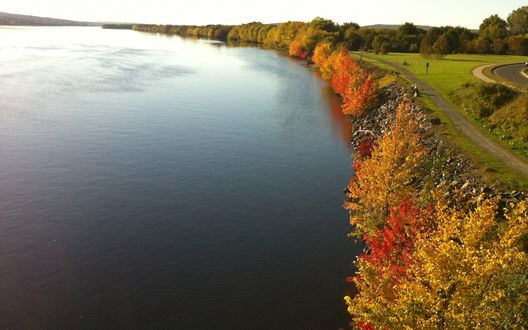

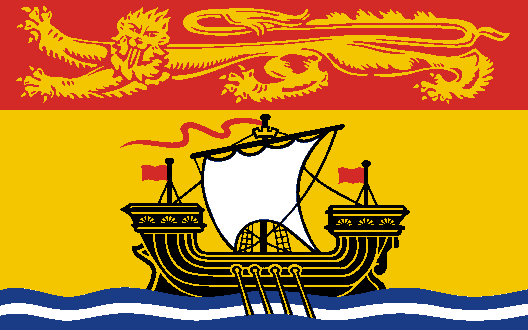

In [14]:
foo = Image.open('stego_1.png')
display(foo)

display(unStego(foo))